[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/bsipocz/astroML-notebooks/notebooks?filepath=chapter6/Figure6-5.ipynb)

# Searching for Structure in Point Data

### First we import data
The data used in this chapter is a subset of SDSS spectroscope galaxy sample centered at SDSS "Great Wall".

In [59]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

The code below ensures the fonts in plots are rendered LaTex.  
This function adjusts matplotlib settings for a uniform feel in the textbook.  
Note that with usetex=True, fonts are rendered with LaTeX.  This may
result in an error if LaTeX is not installed on your system.  In that case,
you can set usetex to False.

In [60]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

## Generate our data

Generate our data: a mix of several Cauchy distributions
this is the same data used in the Bayesian Blocks figure

In [61]:
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

### Generating Distribution
plot the result of the generating distribution of the given dataset.

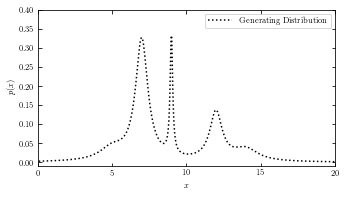

In [62]:
# adjust figure size
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
ax = fig.add_subplot(111)
t = np.linspace(-10, 30, 1000)

# plot_generating_data(x_values) takes a row vector with x values as parameter 
# and plots the generating distribution of the given data using true_pdf() function.
def plot_generating_data(x_values):
    ax.plot(x_values, true_pdf(x_values), ':', color='black', zorder=3,
                label="Generating Distribution")
    # label the plot
    ax.set_ylabel('$p(x)$')

    # set axis limit
    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plot_generating_data(t)
ax.legend(loc='upper right')
ax.set_xlabel('$x$')

plt.show()

## Plot the results

### Kernel Density Estimation (KDE)

We often use Gaussian Kernel in KDE. Function $K(u)$ represents the weight at a given point, which is normalized such that $\int K(u)du = 1$.  
For a Gaussian Kernel:
$$K(u) = \frac{1}{ {2\pi}^{\frac{D}{2}} } e^{\frac{-{u}^2}{2}}$$

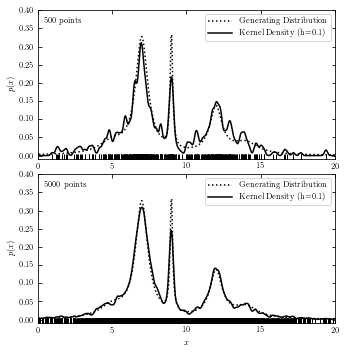

In [63]:
# with functions

# adjust figure size
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
subplots = (211, 212)

# set N values to be 500 and 5000
N_values = (500, 5000)

# plot_kde(x_values) takes a row vector with x values as a parameter, computes the and plots KDE at x.
def plot_kde(x_values):
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))
    ax.plot(x_values, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    
for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    
    # plot generating data in comparison with KDE
    plot_generating_data(t)
    plot_kde(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    
    # make label and legend to the plot
    ax.legend(loc='upper right')
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

    if subplot == 212:
        ax.set_xlabel('$x$')

plt.show()

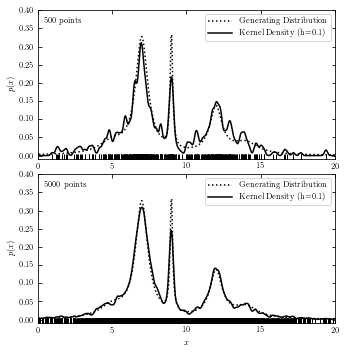

In [64]:
# without functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)
    
# Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))
    
# plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")
    
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')
    
    # set axis limit
    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)
    
    if subplot == 212:
        ax.set_xlabel('$x$')

plt.show()

### Nearest-Neighbor Density Estimation

The code below plots generating distribution and a result from nearest-neighbor estimation.

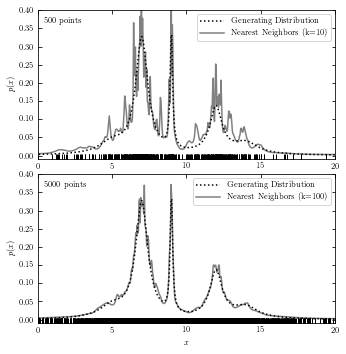

In [65]:
# with functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

k_values = (10, 100)

# plot_nearest_neighor(x_values) takes a row vector with x values as a parameter
# computes the and plots density with Bayesian nearest neighbors at x.
def plot_nearest_neighbor(x_values):
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N
    ax.plot(x_values, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot generating data in comparison with nearest neighbor
    plot_generating_data(t)
    plot_nearest_neighbor(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    
    # make label and legend to the plot
    ax.legend(loc='upper right')
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

    if subplot == 212:
        ax.set_xlabel('$x$')

plt.show()

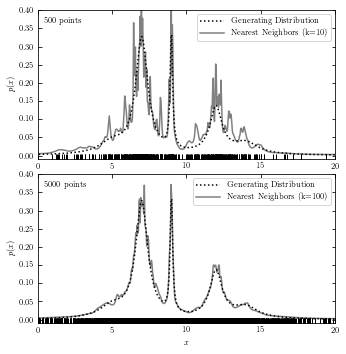

In [66]:
# without function
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
subplots = (211, 212)
N_values = (500, 5000)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)
    
    # Compute density with Bayesian nearest neighbors
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N
    
    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
             
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

### Bayesian Blocks

The code below plots generating distribution and Baysian block analysis.

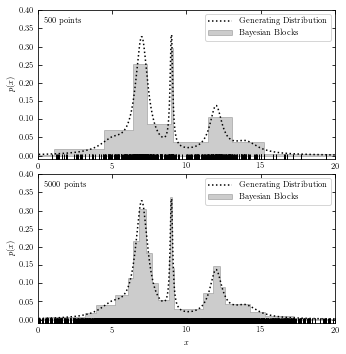

In [67]:
# with functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

# plot_bayesian_block(x_values) takes a row vector with x values as a parameter
# computes the and plots the estimated Bayesian blocks using histogram.
def plot_bayesian_block(x_values):
    hist(x_values, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot generating data in comparison with bayesian blocks
    plot_generating_data(t)
    plot_bayesian_block(xN)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')

    # make label and legend to the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

plt.show()

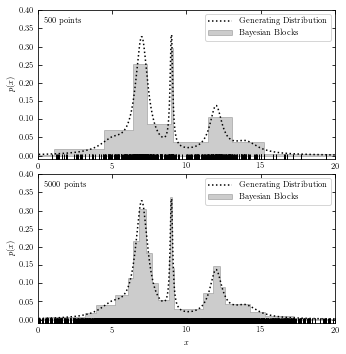

In [68]:
# without functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)
    
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")
    
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

### A comparison of the Three Estimations

The code below plots results from all three estimations in two subplots for reference.

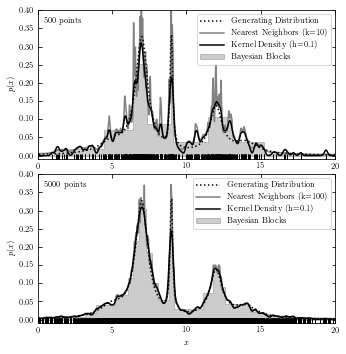

In [69]:
# with functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot the results from three methods and generating data
    plot_generating_data(t)
    plot_bayesian_block(xN)
    plot_nearest_neighbor(t)
    plot_kde(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

plt.show()

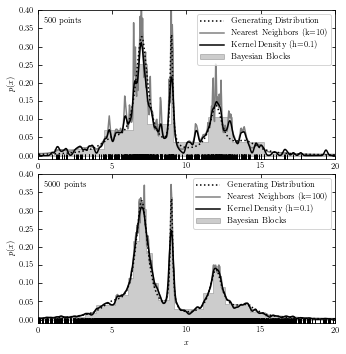

In [70]:
# without functions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)
    
    # Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density with Bayesian nearest neighbors
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")
    ax.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()